In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [ ]:
def sumd_factor(df, window=10):
    """
    计算SUMD因子（总收益与总损失之间的差异比率）
    公式：(Sum(Greater(close-Ref(close, 1), 0), window) - 
          Sum(Greater(Ref(close, 1)-close, 0), window)) /
          (Sum(Abs(close-Ref(close, 1)), window) + 1e-12)
    
    参数:
    df: 包含OHLCV数据的DataFrame
    window: 滚动窗口大小 (默认10)
    """
    close = df['close']
    
    # 计算价格变化
    price_diff = close.diff()
    
    # 计算收益部分（价格上涨）
    gain = price_diff.where(price_diff > 0, 0)
    
    # 计算损失部分（价格下跌）
    loss = (-price_diff).where(price_diff < 0, 0)
    
    # 计算滚动窗口内的总收益
    sum_gain = gain.rolling(window).sum()
    
    # 计算滚动窗口内的总损失
    sum_loss = loss.rolling(window).sum()
    
    # 计算总绝对变化
    sum_abs = (sum_gain + sum_loss) + 1e-12
    
    # 计算SUMD因子
    factor = (sum_gain - sum_loss) / sum_abs
    
    return factor

# 因子测试

In [6]:
# 定义要测试的窗口大小
windows = [5, 10, 20, 30, 60]


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.006471
   Rank_IC (Spearman): -0.027118
📊 信息比率:
   IR: -0.142672
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130929
   因子列: SUMD_5
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


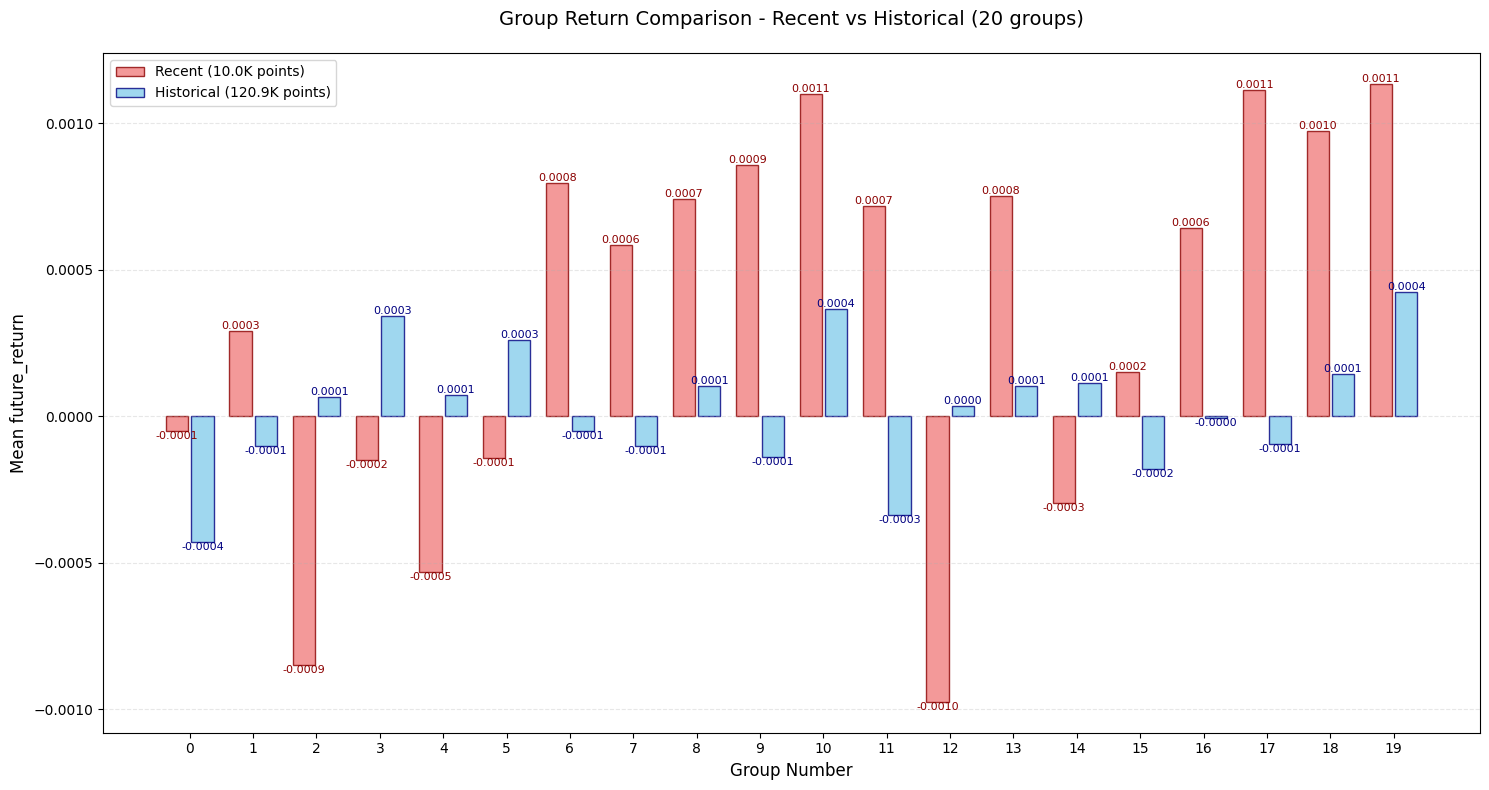

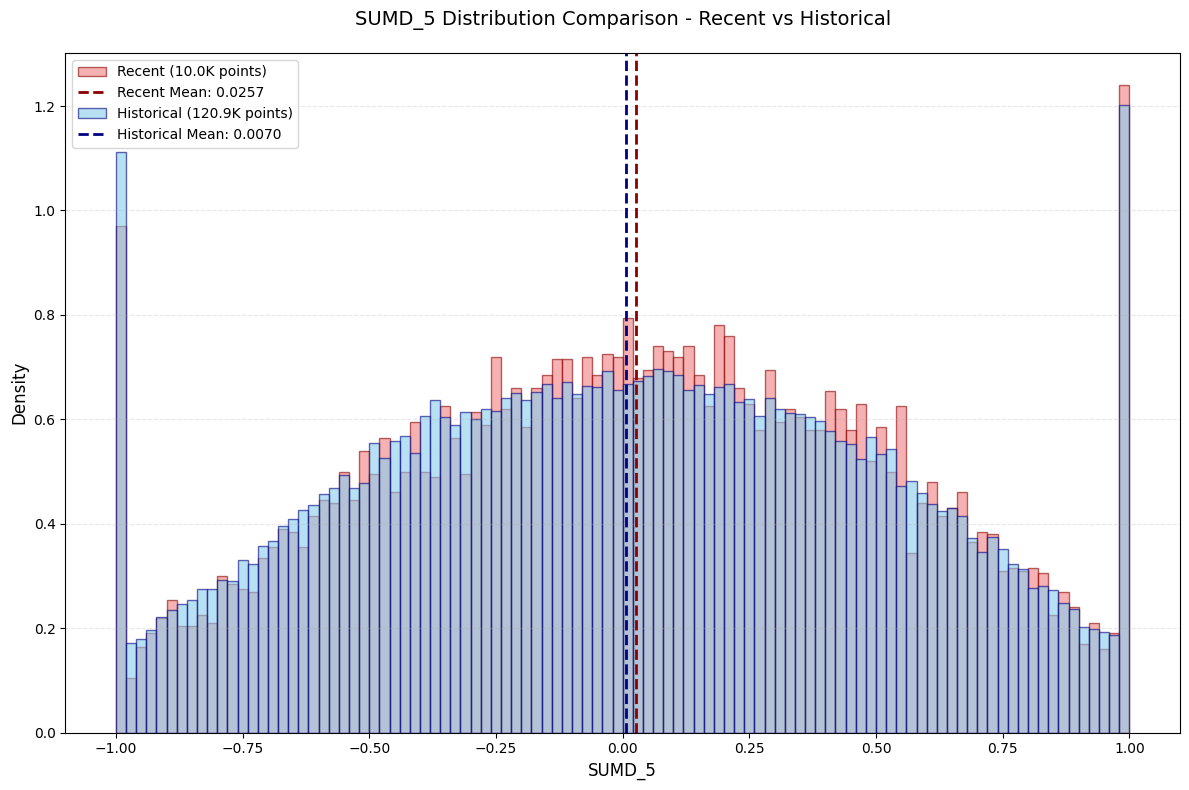

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------

📊 SUMD_5 评估结果:


KeyError: 'ic'

In [9]:
# 循环测试不同窗口大小的SUMD因子
results = {}
for w in windows:
    factor_name = f'SUMD_{w}'
    
    evaluator.set_factor(
        factor_func=lambda df, w=w: sumd_factor(df, w),  # 使用lambda固定窗口参数
        factor_name=factor_name
    )
    
    # 运行评估
    result = evaluator.run_full_evaluation(run_stationarity_test=False)
    results[factor_name] = result
    
    # 打印简要结果
    print(f"\n📊 {factor_name} 评估结果:")
    print(f"IC: {result['ic']:.6f}")
    print(f"Rank IC: {result['rank_ic']:.6f}")
    print(f"IR: {result['ir']:.6f}")

In [ ]:
# 分析不同窗口的表现
print("\n不同窗口SUMD因子表现对比:")
for w in windows:
    factor_name = f'SUMD_{w}'
    res = results[factor_name]
    print(f"{factor_name}: IC={res['ic']:.6f}, Rank IC={res['rank_ic']:.6f}, IR={res['ir']:.6f}")

# 找出表现最好的窗口
best_window = max(windows, key=lambda w: abs(results[f'SUMD_{w}']['ir']))
print(f"\n最佳表现窗口: {best_window} (IR={results[f'SUMD_{best_window}']['ir']:.6f})")